In [1]:
# imports
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import joblib
from models.mlp import build_mlp
from utils.data_loader import load_for_mlp

In [2]:
# load data
features, targets = load_for_mlp(start_year=1958, end_year=2018, datasets=["exp1","exp5","exp6","exp7"])
    
mask = features[:, 10] == 1
features = np.delete(features, [10], axis=1)
features = features[mask]
targets = targets[mask]

N = 60_000_000  # number of samples you want
rng = np.random.default_rng(seed=42)   # seed for reproducibility
idx = rng.choice(len(features), size=N, replace=False)

filtered_features = features[idx]
filtered_targets = targets[idx]

X_train = filtered_features[:int(0.8 * len(filtered_features))]
Y_train = filtered_targets[:int(0.8 * len(filtered_targets))]
X_val = filtered_features[int(0.8 * len(filtered_features)):int(0.9 * len(filtered_features))]
Y_val = filtered_targets[int(0.8 * len(filtered_targets)):int(0.9 * len(filtered_targets))]
X_test = filtered_features[int(0.9 * len(filtered_features)):]
Y_test = filtered_targets[int(0.9 * len(filtered_targets)):]

feature_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

# save scaler
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
folder_path = "../../outputs/mlp/" + timestamp
os.makedirs(folder_path, exist_ok=True)

joblib.dump(feature_scaler, folder_path + '/scaler.pkl')

['../../outputs/mlp/2025-09-29_08-02/scaler.pkl']

In [3]:
# define model

n_epochs = 200
batch_size = 1024
lr = 0.0002 
baseLayerSize = 512
dropoutRate = 0.05 
l2_reg = 0

model = build_mlp(base_layer_size=baseLayerSize, dropout_rate=dropoutRate, l2_reg=l2_reg, lr=lr)
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )

In [4]:
# start training

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
 
history = model.fit(
    X_train,
    Y_train,
    steps_per_epoch=8000,
    epochs=n_epochs,             
    batch_size=batch_size,          
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 303s 38ms/step - loss: 0.2404 - mae: 0.3153 - val_loss: 0.1276 - val_mae: 0.2154 - learning_rate: 2.0000e-04
Epoch 2/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 298s 37ms/step - loss: 0.1258 - mae: 0.2233 - val_loss: 0.1032 - val_mae: 0.1956 - learning_rate: 2.0000e-04
Epoch 3/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 300s 38ms/step - loss: 0.1051 - mae: 0.2019 - val_loss: 0.0889 - val_mae: 0.1765 - learning_rate: 2.0000e-04
Epoch 4/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 298s 37ms/step - loss: 0.0949 - mae: 0.1913 - val_loss: 0.0824 - val_mae: 0.1716 - learning_rate: 2.0000e-04
Epoch 5/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 308s 39ms/step - loss: 0.0893 - mae: 0.1852 - val_loss: 0.0800 - val_mae: 0.1644 - learning_rate: 2.0000e-04
Epoch 6/200
6875/8000 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - loss: 0.0860 - mae: 0.1816

/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 266s 33ms/step - loss: 0.0852 - mae: 0.1808 - val_loss: 0.0756 - val_mae: 0.1630 - learning_rate: 2.0000e-04
Epoch 7/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 305s 38ms/step - loss: 0.0820 - mae: 0.1773 - val_loss: 0.0758 - val_mae: 0.1558 - learning_rate: 2.0000e-04
Epoch 8/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 315s 39ms/step - loss: 0.0795 - mae: 0.1747 - val_loss: 0.0721 - val_mae: 0.1590 - learning_rate: 2.0000e-04
Epoch 9/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 308s 38ms/step - loss: 0.0779 - mae: 0.1725 - val_loss: 0.0762 - val_mae: 0.1600 - learning_rate: 2.0000e-04
Epoch 10/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 303s 38ms/step - loss: 0.0760 - mae: 0.1706 - val_loss: 0.0722 - val_mae: 0.1526 - learning_rate: 2.0000e-04
Epoch 11/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 299s 37ms/step - loss: 0.0745 - mae: 0.1690 - val_loss: 0.0660 - val_mae: 0.1486 - learning_rate: 2.0000e-04
Epoch 12/200
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 278s 35ms/step - loss: 0.0736 - mae: 0.1676 - val_loss

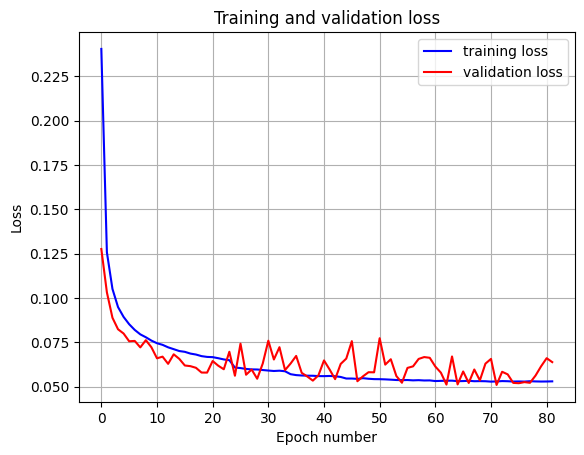

In [5]:
# save model
model.save(folder_path + "/model.keras")

#  save training history
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

path = folder_path + '/training_history.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [6]:
test_pred = model.predict(X_test)

mse = mean_squared_error(test_pred, Y_test)
mae = mean_absolute_error(test_pred, Y_test)
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

187500/187500 ━━━━━━━━━━━━━━━━━━━━ 251s 1ms/step
Mean Squared Error: 0.050
Mean Absolute Error: 0.131


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


135270/135270 ━━━━━━━━━━━━━━━━━━━━ 144s 1ms/step
135270/135270 ━━━━━━━━━━━━━━━━━━━━ 152s 1ms/step
135270/135270 ━━━━━━━━━━━━━━━━━━━━ 134s 993us/step


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/src/utils/model_analysis.py:273: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


135270/135270 ━━━━━━━━━━━━━━━━━━━━ 135s 998us/step


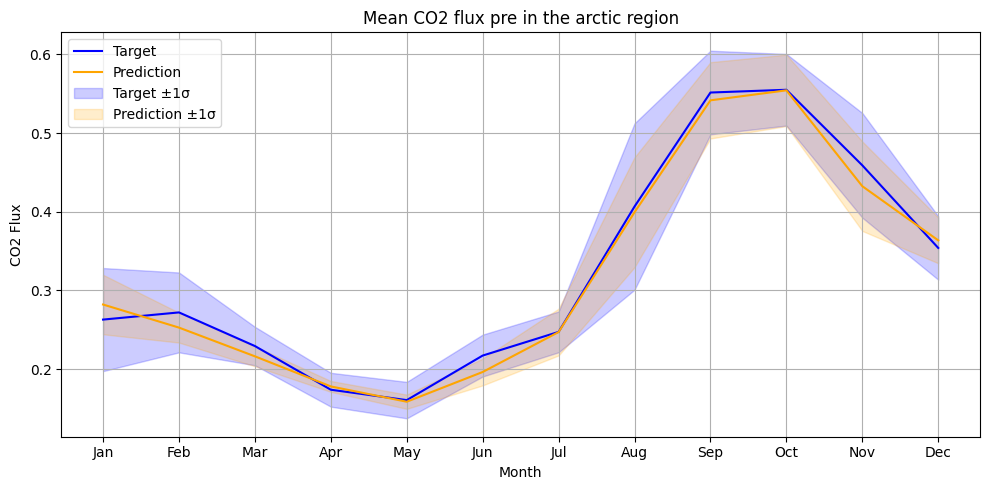

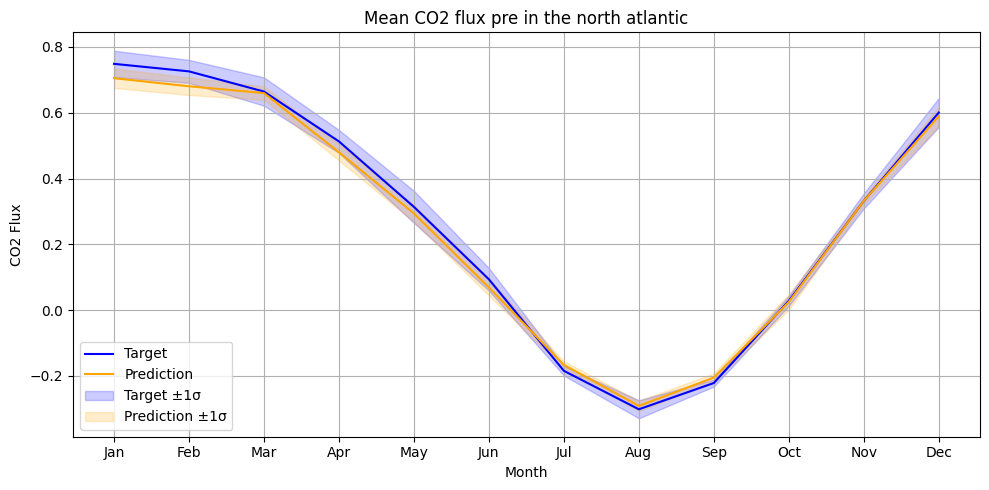

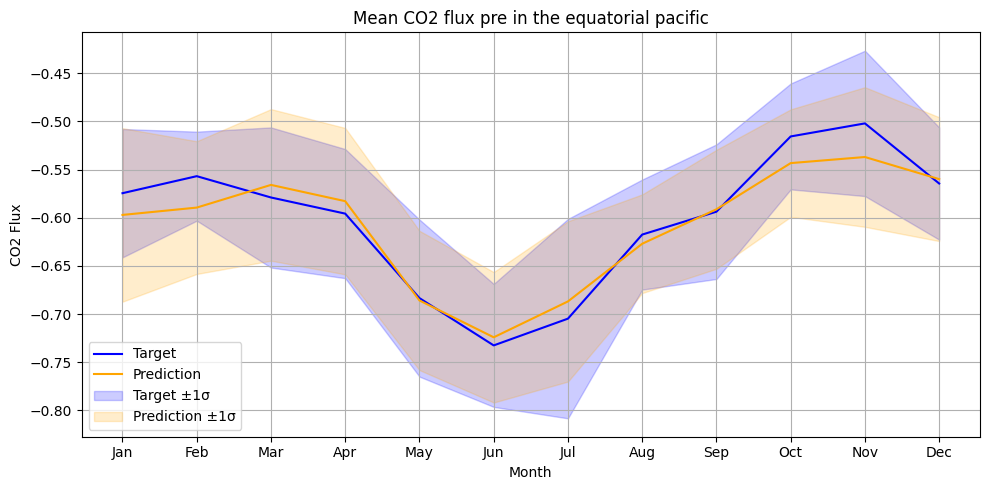

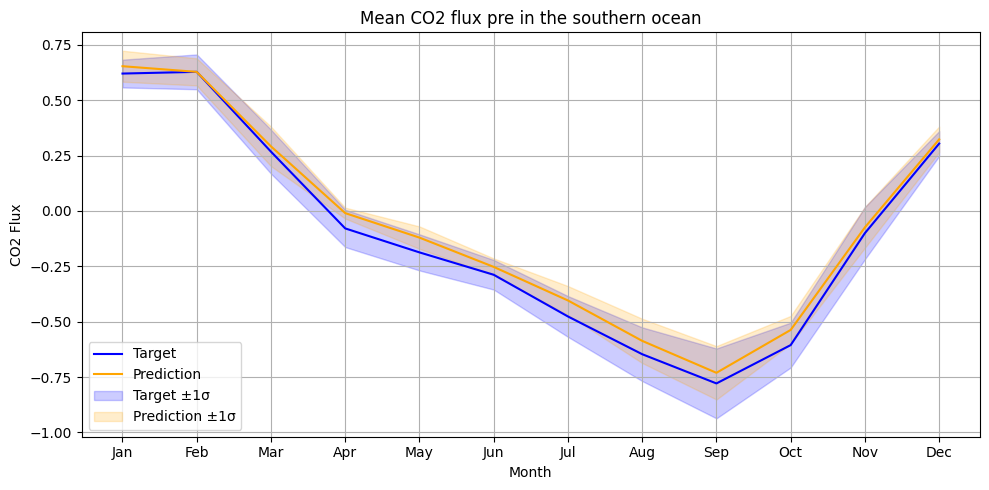

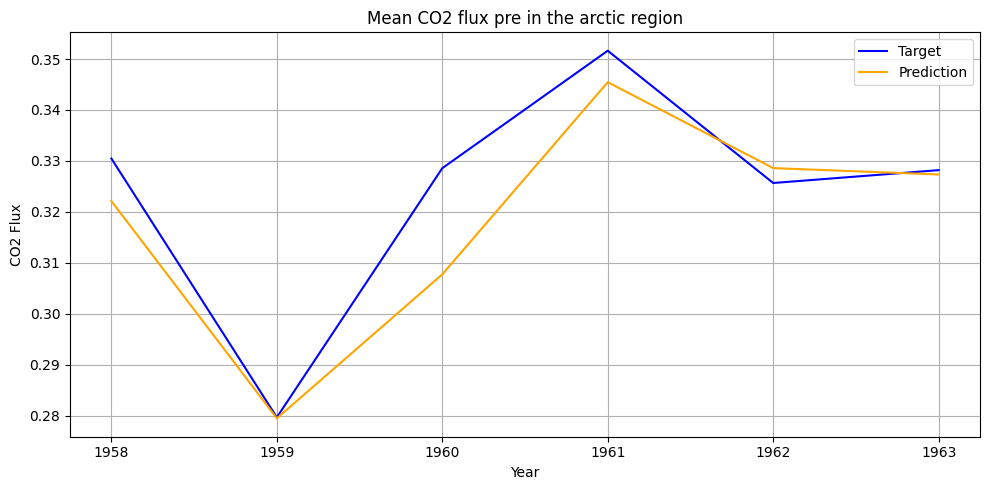

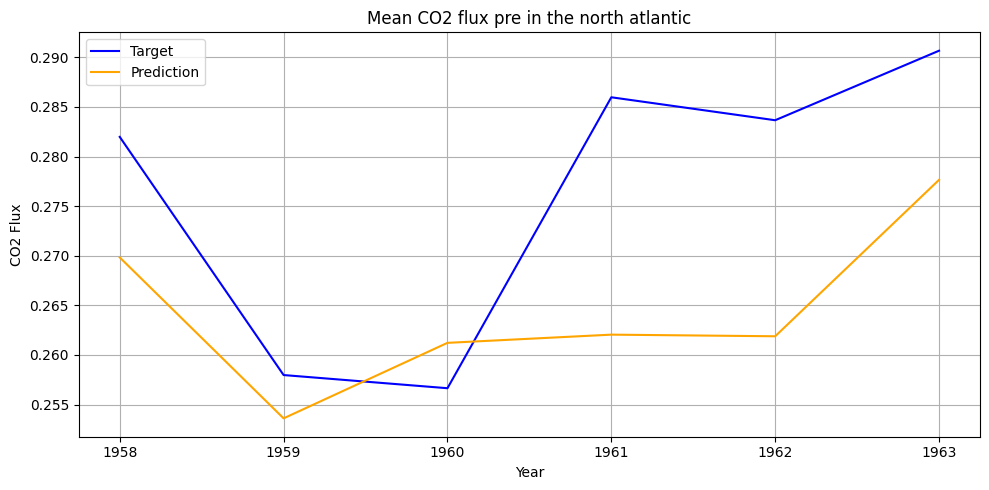

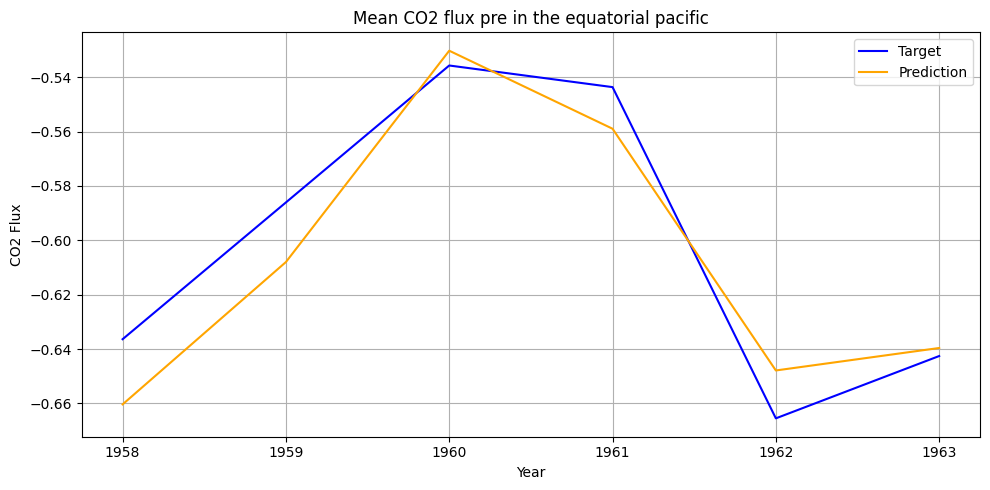

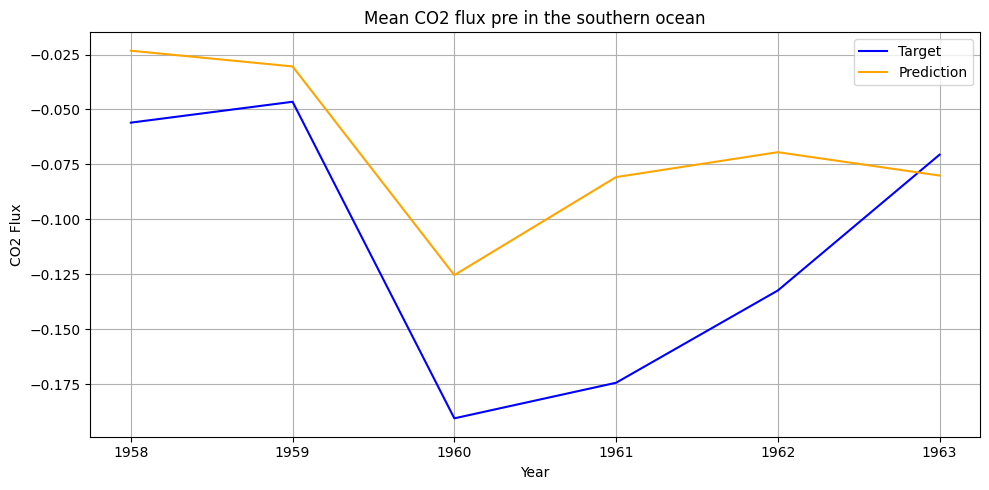

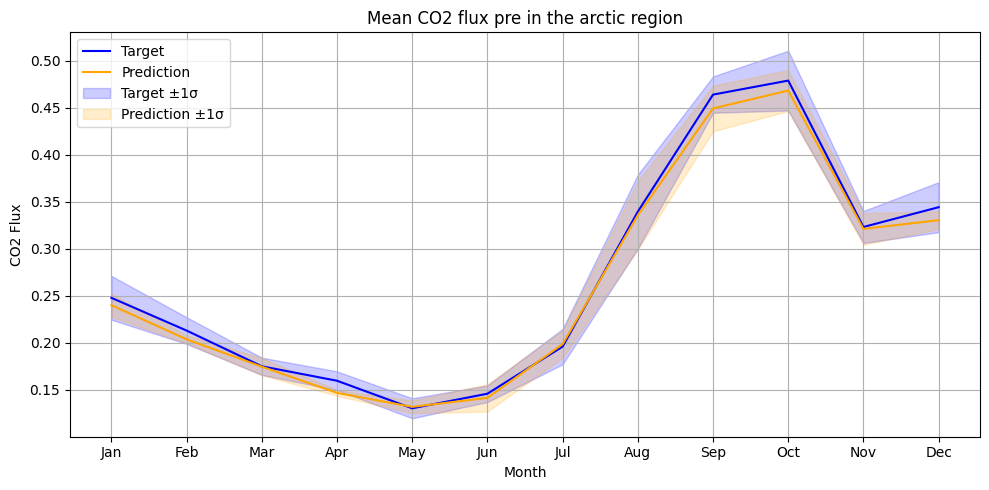

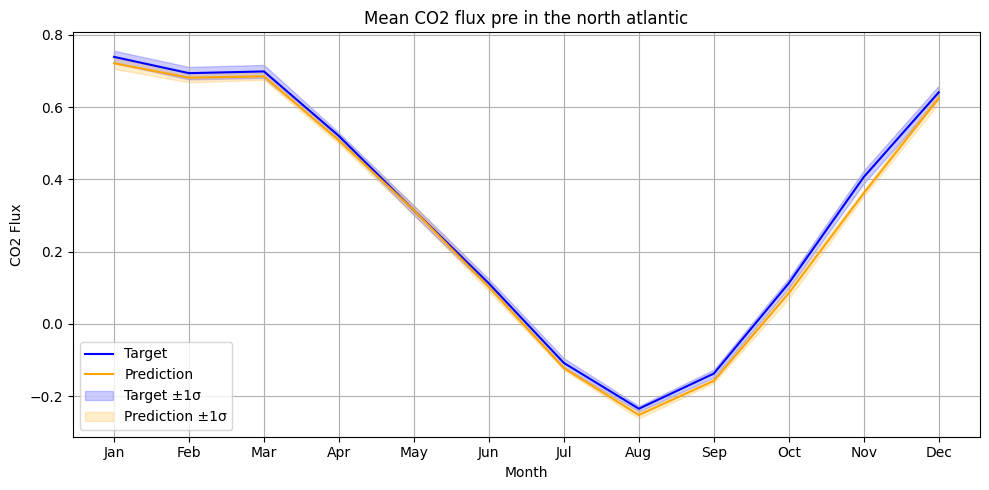

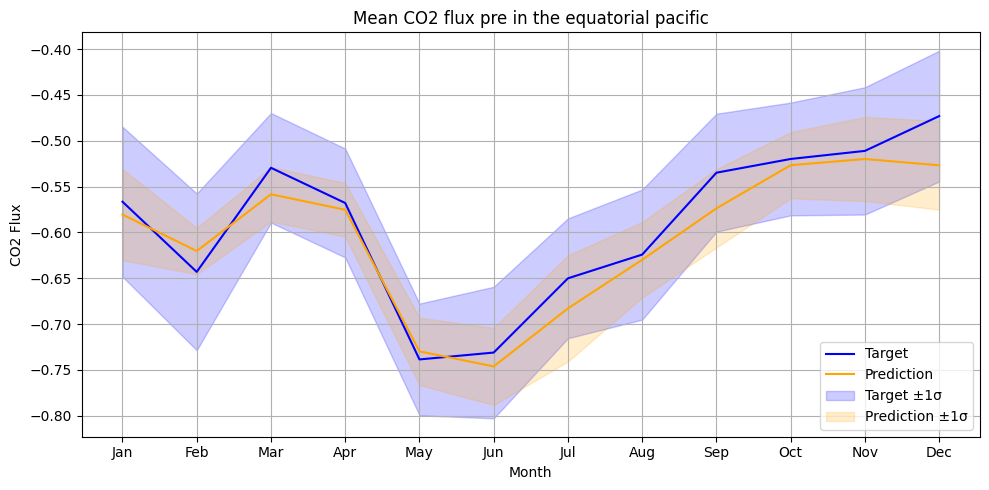

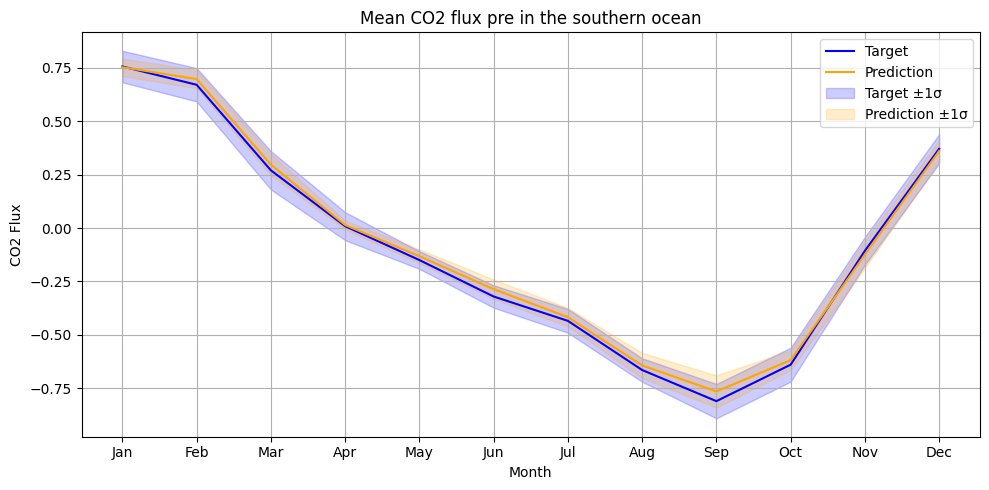

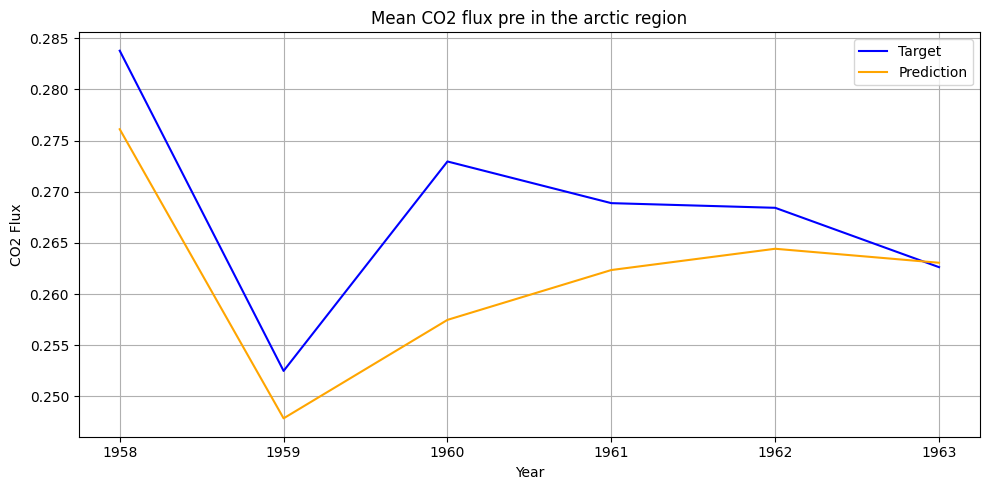

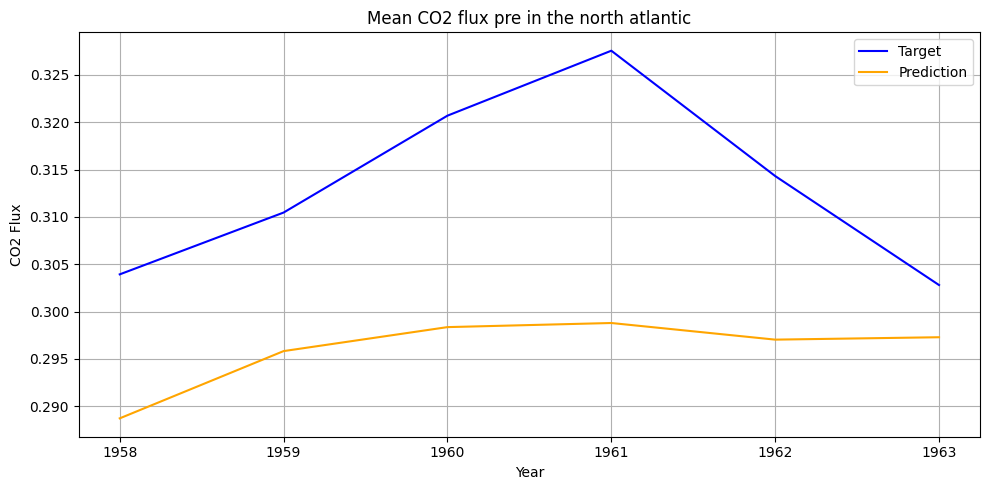

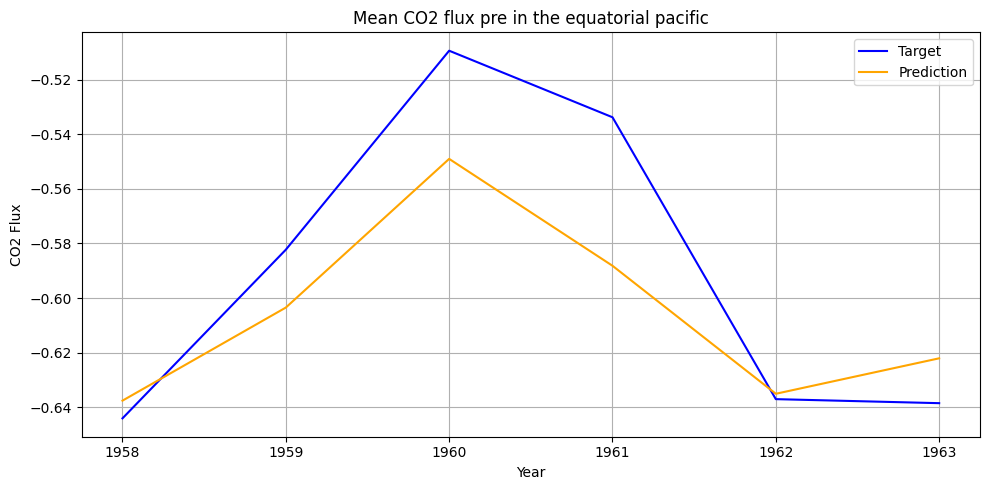

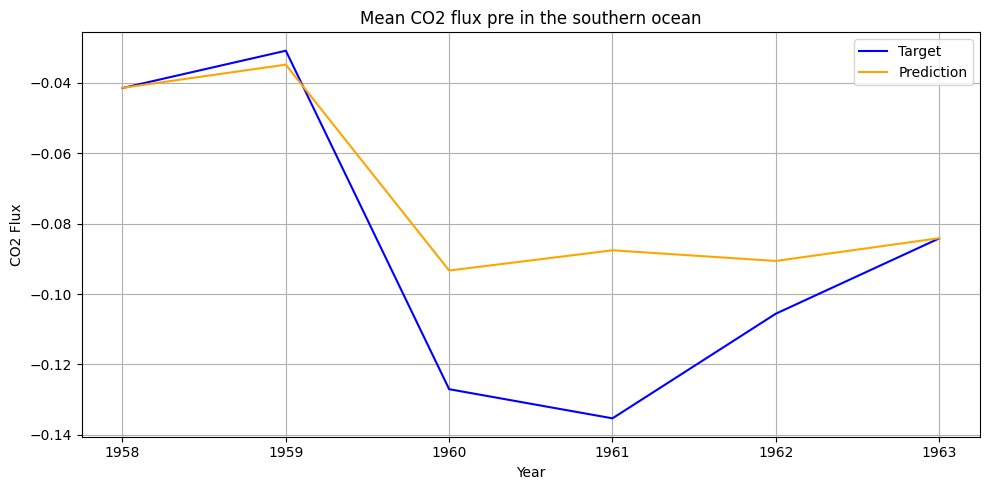

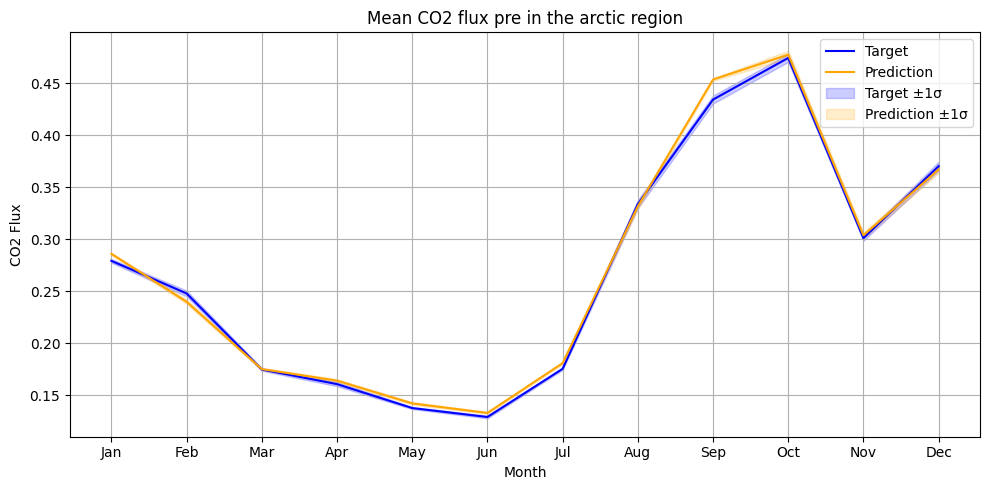

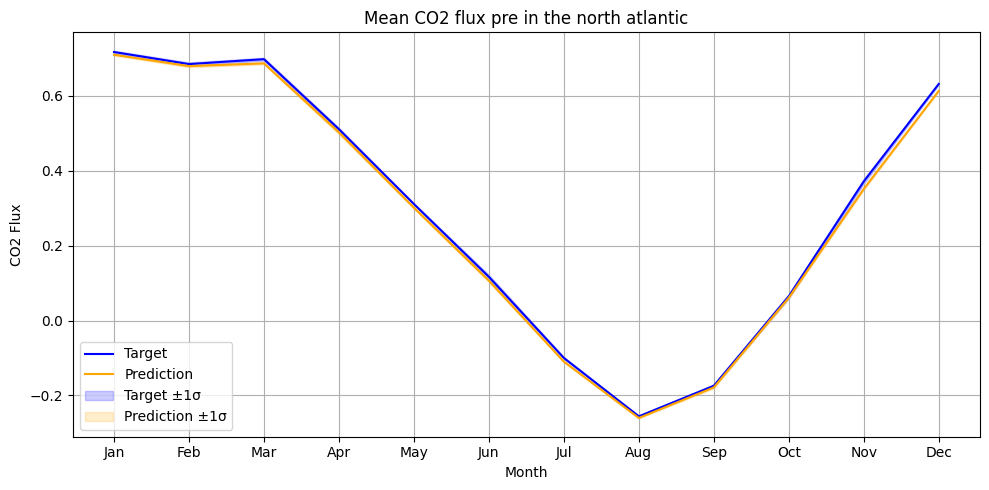

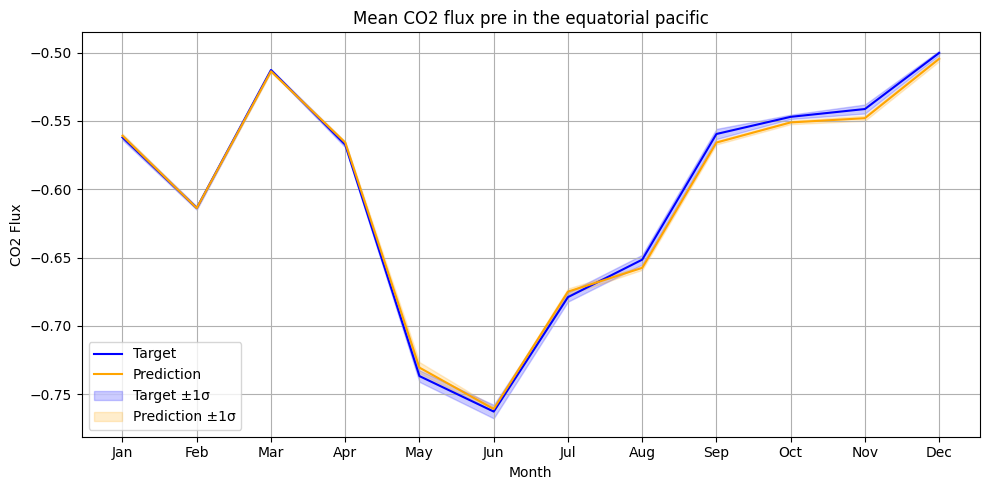

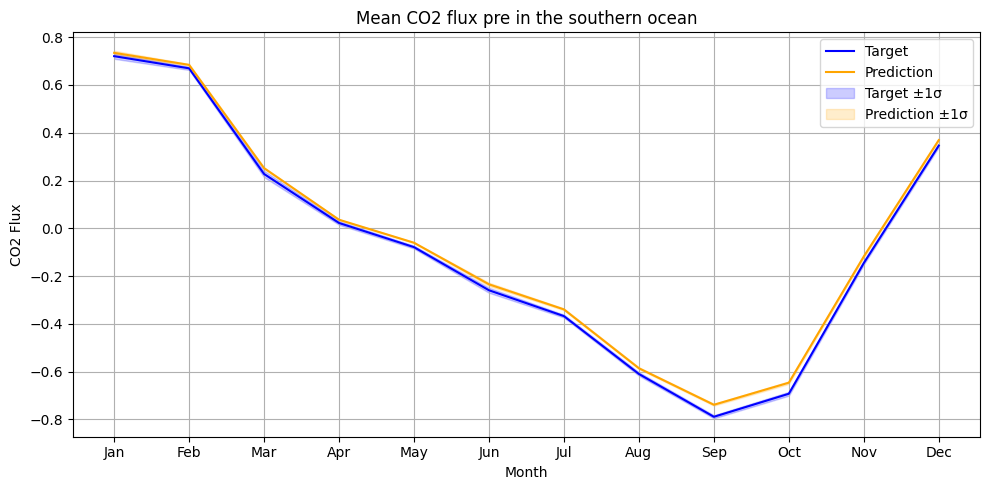

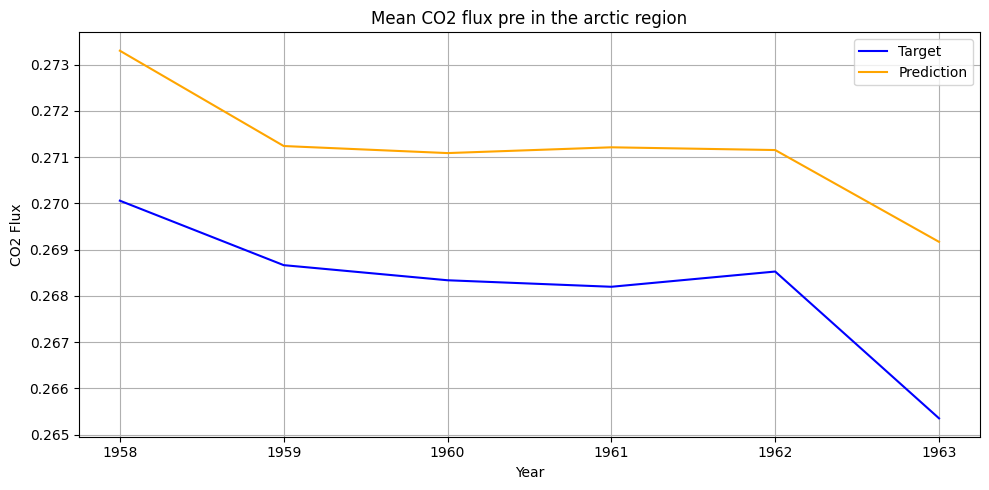

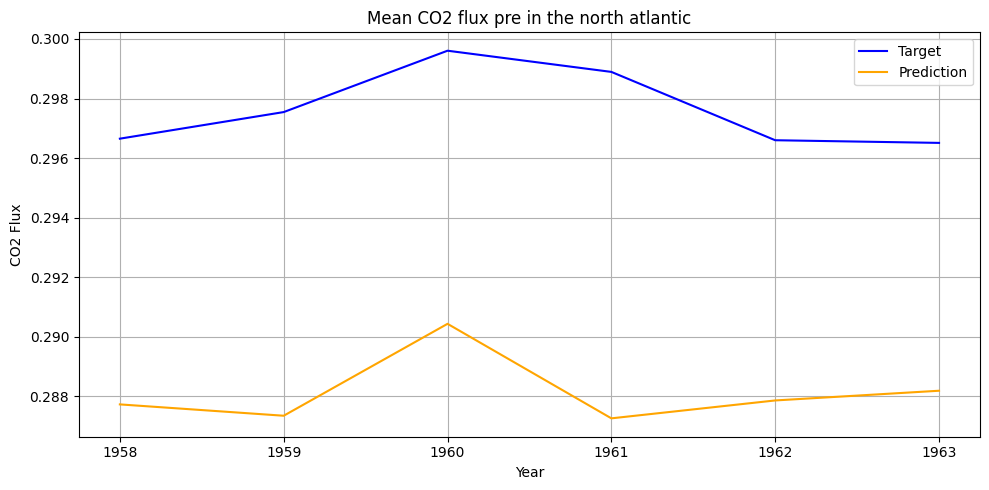

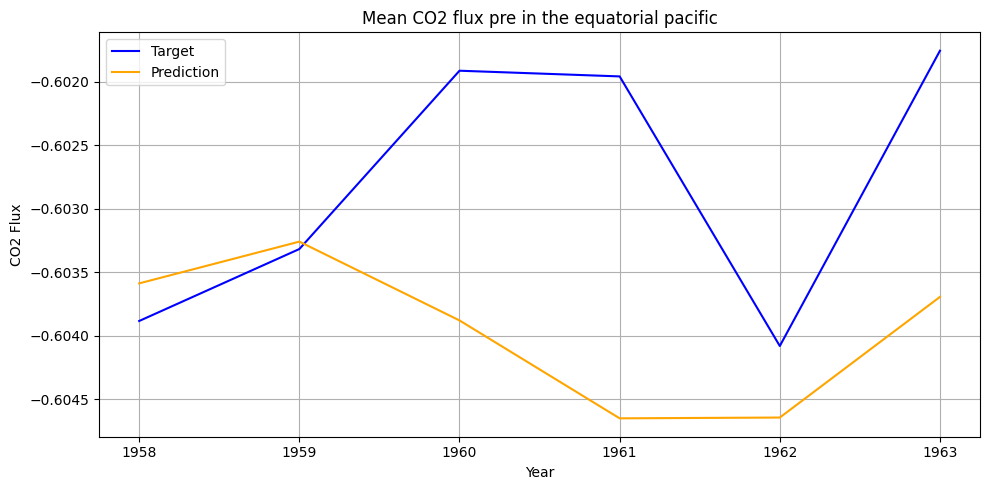

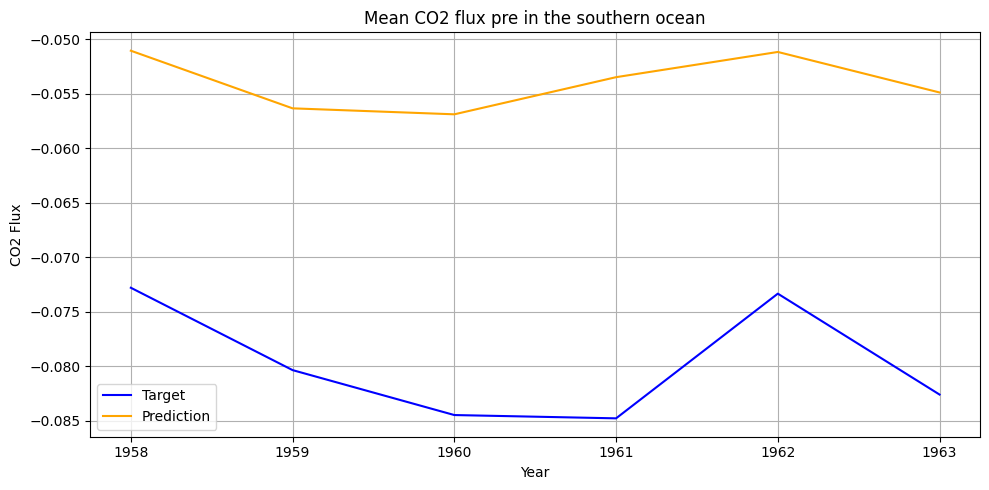

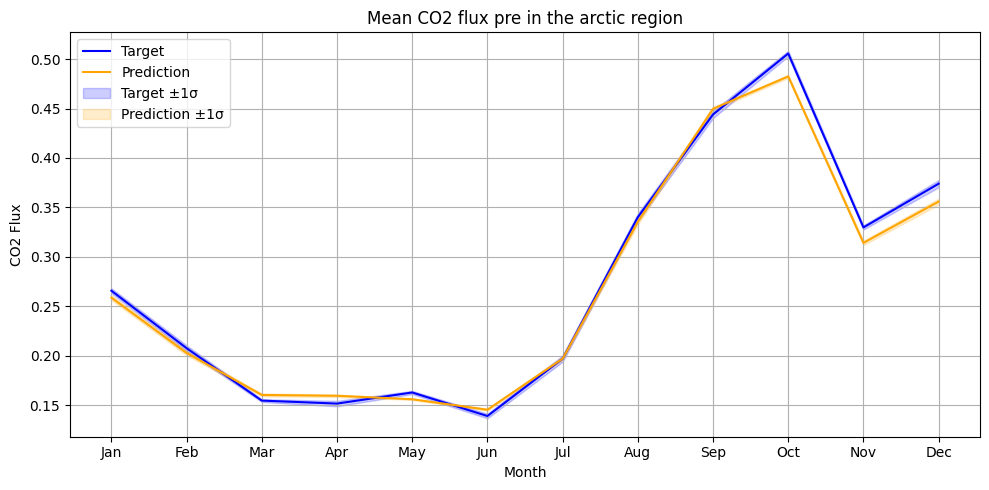

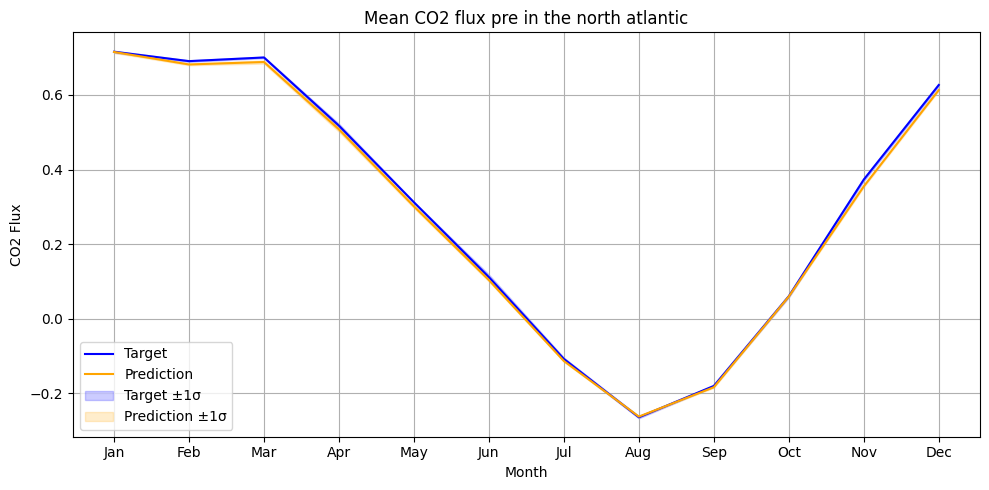

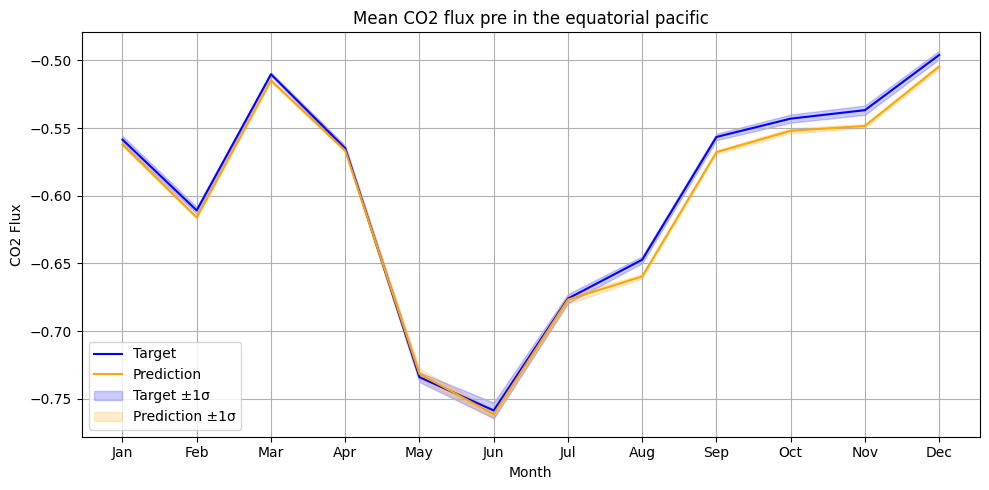

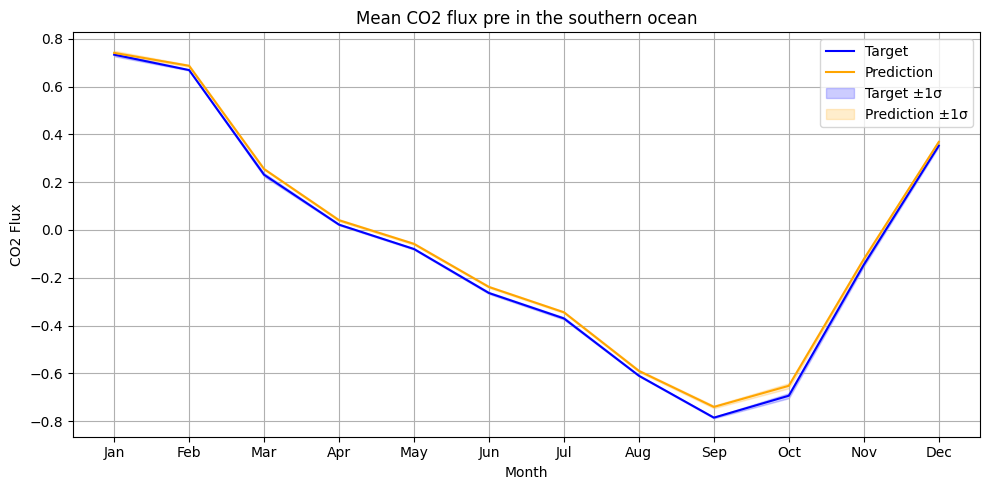

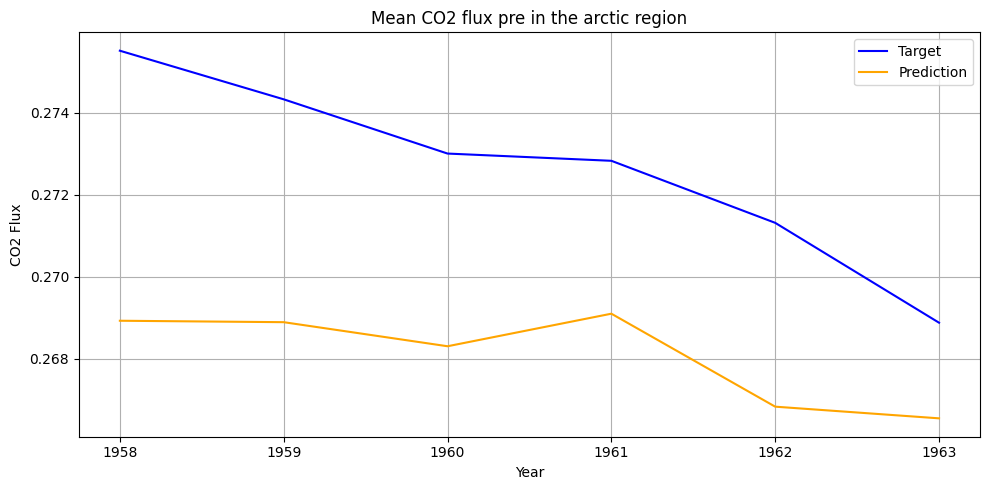

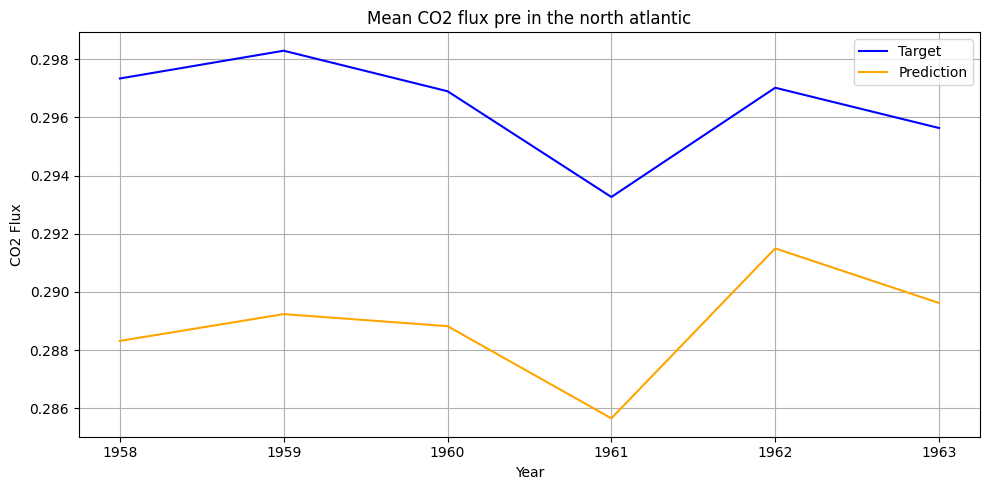

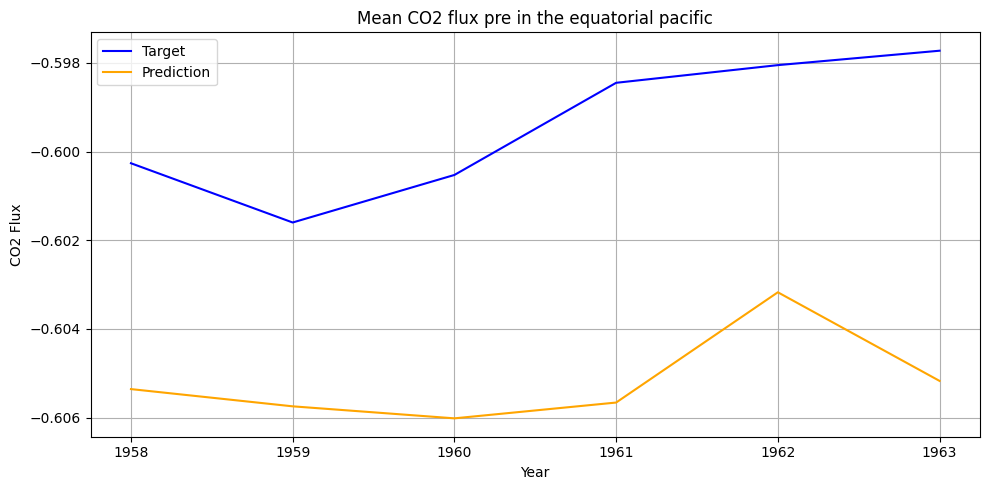

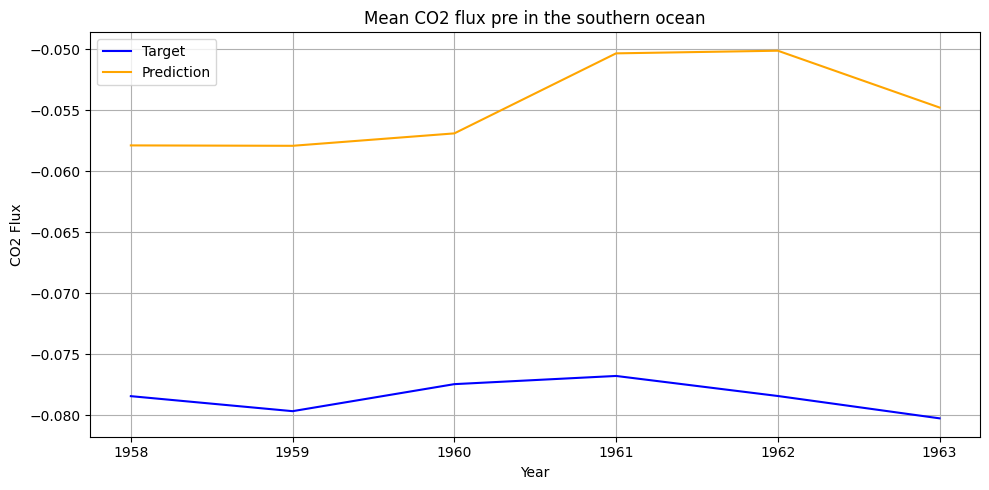

In [7]:
from utils.model_analysis import complete_model_analysis_mlp

complete_model_analysis_mlp(folder_path,"exp1")
complete_model_analysis_mlp(folder_path,"exp5")
complete_model_analysis_mlp(folder_path,"exp6")
complete_model_analysis_mlp(folder_path,"exp7")

# complete_model_analysis_mlp("../../outputs/mlp/2025-09-28_15-39","exp1")
# complete_model_analysis_mlp("../../outputs/mlp/2025-09-28_15-39","exp5")
# complete_model_analysis_mlp("../../outputs/mlp/2025-09-28_15-39","exp6")
# complete_model_analysis_mlp("../../outputs/mlp/2025-09-28_15-39","exp7")
# complete_model_analysis_mlp(folder_path,"exp1")
# complete_model_analysis_mlp(folder_path,"exp3")
# complete_model_analysis_mlp(folder_path,"exp5")
